Step 0: libraries & static variables

In [53]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [54]:
# Define the alpha value for the post-plasma materials
alpha = 0.75

# Define the color for each material
packing_colors = {
    'SiO₂@TiO₂  3 h': (86/255, 180/255, 233/255),
    'SiO₂@TiO₂  6 h': (0/255, 114/255, 178/255),
    'SiO₂@TiO₂  9 h': (230/255, 159/255, 0/255),
    'SiO₂@TiO₂ 12 h': (213/255, 94/255, 0/255)
}

# determine order of materials for plotting
packing_order = [
    'SiO₂@TiO₂  3 h',
    'SiO₂@TiO₂  6 h',
    'SiO₂@TiO₂  9 h',
    'SiO₂@TiO₂ 12 h',      
]

t_quantile = stats.t.ppf(1 - 0.05/2, 7)

In [55]:
# Use Times New Roman font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

# Set font size
plt.rcParams['font.size'] = 7

Step 1: Import & prepare the data

In [56]:
# Importing the dataset
# set the folder and file name
folder_path = r'N:\FWET\FDCH\AdsCatal\General\personal_work_folders\plasmacatdesign\co2-splitting\uhasselt'
file_path = os.path.join(
    folder_path,
    'uhasselt_co2_splitting_reaction_data_combined.csv'
)

# read the Excel file
df_reaction_temp = pd.read_csv(file_path)

# Preparing the data for all plots
df_reaction = df_reaction_temp[
    df_reaction_temp['res_time_sec'] <= 80
].assign(
    compound=lambda x: x['compound'].map(
        {
            'CO2': 'CO₂',
            'CO': 'CO',
            'O2': 'O₂',
            'N2': 'N₂'
        }
    ),
    packing=lambda x: x['packing'].map(
        {
            'SiO2@Anatase TiO2 - 220/03H': 'SiO₂@TiO₂  3 h',
            'SiO2@Anatase TiO2 - 220/06H': 'SiO₂@TiO₂  6 h',
            'SiO2@Anatase TiO2 - 220/09H': 'SiO₂@TiO₂  9 h',
            'SiO2@Anatase TiO2 - 220/12H': 'SiO₂@TiO₂ 12 h',
            'SiO2 Type S 1.6-1.8 mm': 'SiO₂ Type S'
        }
    )
).query(
    'packing in ["SiO₂@TiO₂  3 h", "SiO₂@TiO₂  6 h", "SiO₂@TiO₂  9 h", "SiO₂@TiO₂ 12 h"]'
).reset_index(
).copy()

In [57]:
file_path = os.path.join(
    folder_path,
    'uhasselt_co2_spl_electrical_data_combined.csv'
)

# read the Excel file
df_electrical = pd.read_csv(file_path)

df_electrical_mean = df_electrical[
    (df_electrical['residence_time_s'] <= 80) &
    (df_electrical['plasma_state'] == 'plasma')
].assign(
    material_name=lambda x: x['material_name'].map(
        {
            'SiO2@Anatase_TiO2-220-03H': 'SiO₂@TiO₂  3 h',
            'SiO2@Anatase_TiO2-220-06H': 'SiO₂@TiO₂  6 h',
            'SiO2@Anatase_TiO2-220-09H': 'SiO₂@TiO₂  9 h',
            'SiO2@Anatase_TiO2-220-12H': 'SiO₂@TiO₂ 12 h'
        }
    ),
    U_pp_kV=lambda x: x['U_pp_V'] / 1000,
    displaced_charge_nC=lambda x: x['displaced_charge_C'] * 1e9,
    sei_kjmol=lambda x: (x['plasma_power_W'] / 
                         (
                          (1 - 0.4774) *
                          (17.31 / x['residence_time_s'])
                         ) * 24.055
                        ),
    plasma_rms_current_mA=lambda x: x['plasma_rms_current_A'] * 1e3,
    sei_ideal_kjmol=lambda x: round(
        number=30 / ((1 - 0.4774) * (17.31 / x['residence_time_s'])) * 24.055,
        ndigits=-1
    ).astype(int),
    eff_cap_nF=lambda x: x['slope_DA_F'] * 1e9
).query(
    'material_name in ["SiO₂@TiO₂  3 h", "SiO₂@TiO₂  6 h", "SiO₂@TiO₂  9 h", "SiO₂@TiO₂ 12 h"]'
).groupby(
    [
        'material_name',
        'residence_time_s',
        'sei_ideal_kjmol'
    ]
).agg(
    U_pp_kV=('U_pp_kV', 'mean'),
    U_pp_kV_err=(
        'U_pp_kV',
        lambda x: stats.t.ppf(1 - 0.05/2, len(x)) * x.sem()
    ),
    avg_num_udisch_per_graph=('avg_num_udisch_per_graph', 'mean'),
    avg_num_udisch_per_graph_err=(
        'avg_num_udisch_per_graph',
        lambda x: stats.t.ppf(1 - 0.05/2, len(x)) * x.sem()
    ),
    displaced_charge_nC=('displaced_charge_nC', 'mean'),
    displaced_charge_nC_err=(
        'displaced_charge_nC',
        lambda x: stats.t.ppf(1 - 0.05/2, len(x)) * x.sem()
    ),
    plasma_rms_current_mA=('plasma_rms_current_mA', 'mean'),
    plasma_rms_current_mA_err=(
        'plasma_rms_current_mA',
        lambda x: stats.t.ppf(1 - 0.05/2, len(x)) * x.sem()
    ),
    eff_cap_nF=('eff_cap_nF', 'mean'),
    eff_cap_nF_err=(
        'eff_cap_nF',
        lambda x: stats.t.ppf(1 - 0.05/2, len(x)) * x.sem()
    )
).reset_index(
).copy()

df_electrical_mean.rename(
    columns={
        'material_name': 'packing',
        'residence_time_s': 'res_time_sec'
    },
    inplace=True
)

In [58]:
df_electrical.columns

Index(['psdata_file_name', 'project_name', 'reaction_type',
       'material_supplier', 'material_name', 'wattage_const',
       'residence_time_s', 'measurement_number', 'plasma_state',
       'measurement_date', 'U_min_pos_V', 'U_min_neg_V', 'U_pp_V',
       'slope_AB_F', 'slope_BC_F', 'slope_CD_F', 'slope_DA_F',
       'plasma_power_W', 'source_power_W', 'plasma_rms_current_A',
       'source_rms_current_A', 'avg_num_udisch_per_graph',
       'avg_displ_Q_per_peak_Cperpeak', 'displaced_charge_C',
       'U_burning_neg_V', 'U_burning_pos_V', 'U_breakdown_neg_V',
       'U_breakdown_pos_V'],
      dtype='object')

Step 3: Merge the data

In [59]:
df_combined = pd.merge(
    df_reaction,
    df_electrical_mean,
    on=['packing', 'res_time_sec']
).reset_index()

Step 4: Conv vs electrical data

In [60]:
# Subset the data
df_conv = df_combined[
    [
        'packing',
        'compound',
        'res_time_sec',
        'sei_kjmol',
        'sei_kjmol_sd',
        'sei_ideal_kjmol',
        'conv',
        'conv_sd',
        'U_pp_kV',
        'U_pp_kV_err',
        'displaced_charge_nC',
        'displaced_charge_nC_err',
        'avg_num_udisch_per_graph',
        'avg_num_udisch_per_graph_err',
        'plasma_rms_current_mA',
        'plasma_rms_current_mA_err',
        'eff_cap_nF',
        'eff_cap_nF_err'
    ]
].query(
    "compound in ['CO₂']"
).drop_duplicates(
).assign(
    conv=lambda x: x['conv'] * 100,
    conv_sd=lambda x: x['conv_sd'] * 100,
).groupby(
    [
        'packing',
        'compound',
        'res_time_sec',
        'sei_ideal_kjmol',
        'U_pp_kV',
        'U_pp_kV_err',
        'displaced_charge_nC',
        'displaced_charge_nC_err',
        'avg_num_udisch_per_graph',
        'avg_num_udisch_per_graph_err',
        'plasma_rms_current_mA',
        'plasma_rms_current_mA_err',
        'eff_cap_nF',
        'eff_cap_nF_err'
    ]
).agg(
    conv=('conv', 'mean'),
    conv_err=(
        'conv_sd',
        lambda x: ((x**2).sum()**0.5)/len(x)
        * stats.t.ppf(1 - 0.05/2, len(x) * 7)
    ),
    sei_kjmol=('sei_kjmol', 'mean'),
    sei_kjmol_err=(
        'sei_kjmol_sd',
        lambda x: ((x**2).sum()**0.5)/len(x)
        * stats.t.ppf(1 - 0.05/2, len(x) * 7)
    )
).reset_index(
).sort_values(
    by=['sei_ideal_kjmol', 'compound', 'packing']
).copy()

Step 4.1: Conv vs U_pp

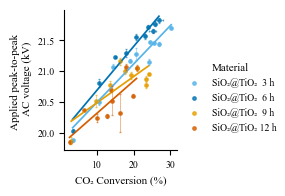

In [61]:
g = sns.lmplot(
    data=df_conv,
    x='conv',
    y='U_pp_kV',
    hue='packing',
    hue_order=packing_order,
    palette=packing_colors,
    height=5/2.54,
    aspect=1,
    scatter_kws={'s': 6, 'alpha': alpha},
    line_kws={'lw': 1.25},
    ci=None
)

ax = g.axes.flatten()[0]

for packing in df_conv['packing'].unique():
    subset = df_conv[df_conv['packing'] == packing]
    ax.errorbar(
        x=subset['conv'],
        y=subset['U_pp_kV'],
        xerr=subset['conv_err'],
        yerr=subset['U_pp_kV_err'],
        fmt='none',
        ecolor=packing_colors[packing],
        elinewidth=0.5,
        capsize=1,
        capthick=0.95,
        alpha=0.6
    )

g.legend.set_title("Material", prop={'size': 8})
g.set_titles(col_template="{col_name}", size=9)
g.set_xlabels("CO₂ Conversion (%)", size=8)
g.set_ylabels("Applied peak-to-peak \n AC voltage (kV)", size=8)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_coating\figs\sander_U_pp_vs_conv.pdf",
    bbox_inches='tight'
)
plt.show()

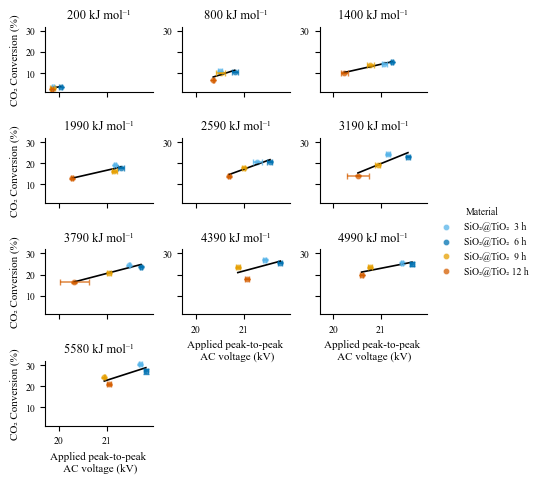

In [87]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='sei_ideal_kjmol',
    col_wrap=3,
    hue='packing',
    hue_order=packing_order,
    palette=packing_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'U_pp_kV',
    'conv',
    s=20,
    alpha=alpha
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, fitting_subset) in zip(
    g.axes.flat,
    df_conv.groupby(['sei_ideal_kjmol'], sort=False)
    ):
    # Apply regplot to the current fitting_subset and axis
    sns.regplot(
        x='U_pp_kV',
        y='conv',
        data=fitting_subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )
    for packing in fitting_subset['packing'].unique():
        error_subset = fitting_subset[fitting_subset['packing'] == packing]
        ax.errorbar(
            x=error_subset['U_pp_kV'],
            y=error_subset['conv'],
            xerr=error_subset['U_pp_kV_err'],
            yerr=error_subset['conv_err'],
            fmt='none',
            ecolor=packing_colors[packing],
            elinewidth=1.1,
            capsize=2,
            alpha=alpha
        )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(col_template="{col_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="Applied peak-to-peak \n AC voltage (kV)",
    y_var="CO₂ Conversion (%)",
    size=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_coating\figs\sander_conv_vs_U_pp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 4.2: Conv vs displ Q

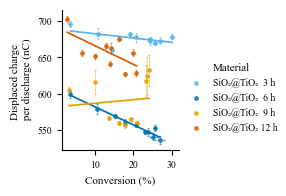

In [91]:
g = sns.lmplot(
    data=df_conv,
    x='conv',
    y='displaced_charge_nC',
    hue='packing',
    hue_order=packing_order,
    palette=packing_colors,
    height=5/2.54,
    aspect=1,
    scatter_kws={'s': 6, 'alpha': alpha},
    line_kws={'lw': 1.25},
    ci=None
)

ax = g.axes.flatten()[0]

for packing in df_conv['packing'].unique():
    subset = df_conv[df_conv['packing'] == packing]
    ax.errorbar(
        x=subset['conv'],
        y=subset['displaced_charge_nC'],
        xerr=subset['conv_err'],
        yerr=subset['displaced_charge_nC_err'],
        fmt='none',
        ecolor=packing_colors[packing],
        elinewidth=0.5,
        capsize=1,
        capthick=0.95,
        alpha=0.6
    )

g.legend.set_title("Material", prop={'size': 8})
g.set_titles(col_template="{col_name}", size=9)
g.set_xlabels("Conversion (%)", size=8)
g.set_ylabels("Displaced charge \n per discharge (nC)", size=8)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_coating\figs\sander_displ_Q_vs_conv.pdf",
    bbox_inches='tight'
)
plt.show()

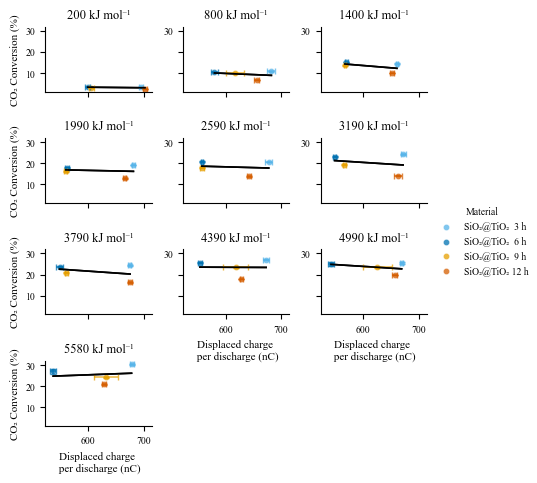

In [88]:

# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='sei_ideal_kjmol',
    col_wrap=3,
    hue='packing',
    hue_order=packing_order,
    palette=packing_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'displaced_charge_nC',
    'conv',
    s=20,
    alpha=alpha
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, fitting_subset) in zip(
    g.axes.flat,
    df_conv.groupby(['sei_ideal_kjmol'], sort=False)
    ):
    # Apply regplot to the current fitting_subset and axis
    sns.regplot(
        x='displaced_charge_nC',
        y='conv',
        data=fitting_subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )
    for packing in fitting_subset['packing'].unique():
        error_subset = fitting_subset[fitting_subset['packing'] == packing]
        ax.errorbar(
            x=error_subset['displaced_charge_nC'],
            y=error_subset['conv'],
            xerr=error_subset['displaced_charge_nC_err'],
            yerr=error_subset['conv_err'],
            fmt='none',
            ecolor=packing_colors[packing],
            elinewidth=1.1,
            capsize=2,
            alpha=alpha
        )

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_conv.groupby(['compound', 'sei_ideal_kjmol'], sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='displaced_charge_nC',
        y='conv',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(col_template="{col_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="Displaced charge \n per discharge (nC)",
    y_var="CO₂ Conversion (%)",
    size=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_coating\figs\sander_conv_vs_displ_Q_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 4.3: Conv vs RMS I

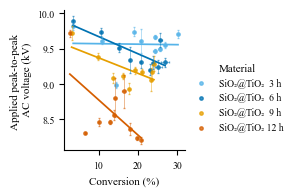

In [89]:
g = sns.lmplot(
    data=df_conv,
    x='conv',
    y='plasma_rms_current_mA',
    hue='packing',
    hue_order=packing_order,
    palette=packing_colors,
    height=5/2.54,
    aspect=1,
    scatter_kws={'s': 6, 'alpha': alpha},
    line_kws={'lw': 1.25},
    ci=None
)

ax = g.axes.flatten()[0]

for packing in df_conv['packing'].unique():
    subset = df_conv[df_conv['packing'] == packing]
    ax.errorbar(
        x=subset['conv'],
        y=subset['plasma_rms_current_mA'],
        xerr=subset['conv_err'],
        yerr=subset['plasma_rms_current_mA_err'],
        fmt='none',
        ecolor=packing_colors[packing],
        elinewidth=0.5,
        capsize=1,
        capthick=0.95,
        alpha=0.6
    )

g.legend.set_title("Material", prop={'size': 8})
g.set_titles(col_template="{col_name}", size=9)
g.set_xlabels("Conversion (%)", size=8)
g.set_ylabels("Applied peak-to-peak \n AC voltage (kV)", size=8)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_coating\figs\sander_rms_reactor_I_vs_conv.pdf",
    bbox_inches='tight'
)
plt.show()

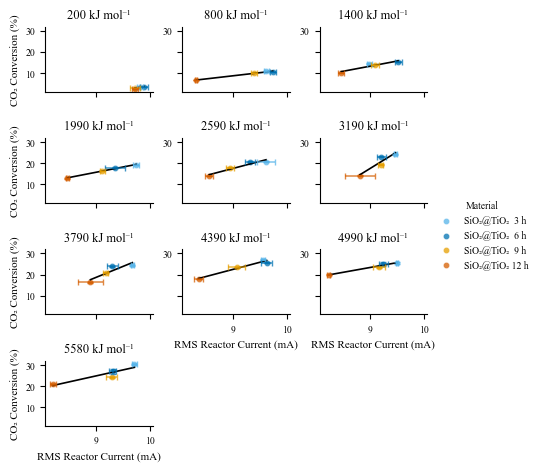

In [90]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='sei_ideal_kjmol',
    col_wrap=3,
    hue='packing',
    hue_order=packing_order,
    palette=packing_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'plasma_rms_current_mA',
    'conv',
    s=20,
    alpha=alpha
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, fitting_subset) in zip(
    g.axes.flat,
    df_conv.groupby(['sei_ideal_kjmol'], sort=False)
    ):
    # Apply regplot to the current fitting_subset and axis
    sns.regplot(
        x='plasma_rms_current_mA',
        y='conv',
        data=fitting_subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )
    for packing in fitting_subset['packing'].unique():
        error_subset = fitting_subset[fitting_subset['packing'] == packing]
        ax.errorbar(
            x=error_subset['plasma_rms_current_mA'],
            y=error_subset['conv'],
            xerr=error_subset['plasma_rms_current_mA_err'],
            yerr=error_subset['conv_err'],
            fmt='none',
            ecolor=packing_colors[packing],
            elinewidth=1.1,
            capsize=2,
            alpha=alpha
        )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(col_template="{col_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="RMS Reactor Current (mA)",
    y_var="CO₂ Conversion (%)",
    size=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_coating\figs\sander_conv_vs_rms_reactor_I_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 4.4: Conv vs # µ-discharges

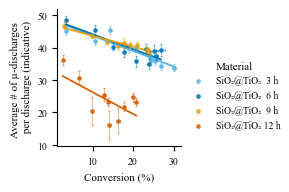

In [92]:
g = sns.lmplot(
    data=df_conv,
    x='conv',
    y='avg_num_udisch_per_graph',
    hue='packing',
    hue_order=packing_order,
    palette=packing_colors,
    height=5/2.54,
    aspect=1,
    scatter_kws={'s': 6, 'alpha': alpha},
    line_kws={'lw': 1.25},
    ci=None
)

ax = g.axes.flatten()[0]

for packing in df_conv['packing'].unique():
    subset = df_conv[df_conv['packing'] == packing]
    ax.errorbar(
        x=subset['conv'],
        y=subset['avg_num_udisch_per_graph'],
        xerr=subset['conv_err'],
        yerr=subset['avg_num_udisch_per_graph_err'],
        fmt='none',
        ecolor=packing_colors[packing],
        elinewidth=0.5,
        capsize=1,
        capthick=0.95,
        alpha=0.6
    )

g.legend.set_title("Material", prop={'size': 8})
g.set_titles(col_template="{col_name}", size=9)
g.set_xlabels("Conversion (%)", size=8)
g.set_ylabels("Indicative # of µ-Discharges\nper Discharge", size=8)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_coating\figs\sander_avg_num_udisch_vs_conv.pdf",
    bbox_inches='tight'
)
plt.show()

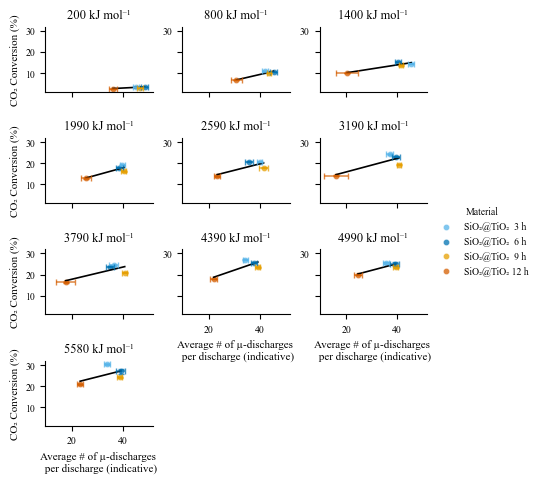

In [93]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='sei_ideal_kjmol',
    col_wrap=3,
    hue='packing',
    hue_order=packing_order,
    palette=packing_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'avg_num_udisch_per_graph',
    'conv',
    s=20,
    alpha=alpha
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, fitting_subset) in zip(
    g.axes.flat,
    df_conv.groupby(['sei_ideal_kjmol'], sort=False)
    ):
    # Apply regplot to the current fitting_subset and axis
    sns.regplot(
        x='avg_num_udisch_per_graph',
        y='conv',
        data=fitting_subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )
    for packing in fitting_subset['packing'].unique():
        error_subset = fitting_subset[fitting_subset['packing'] == packing]
        ax.errorbar(
            x=error_subset['avg_num_udisch_per_graph'],
            y=error_subset['conv'],
            xerr=error_subset['avg_num_udisch_per_graph_err'],
            yerr=error_subset['conv_err'],
            fmt='none',
            ecolor=packing_colors[packing],
            elinewidth=1.1,
            capsize=2,
            alpha=alpha
        )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(col_template="{col_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="Average # of µ-discharges \n per discharge (indicative)",
    y_var="CO₂ Conversion (%)",
    size=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_coating\figs\sander_conv_vs_avg_num_udisch_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 4.5: Conv vs effective capacitance

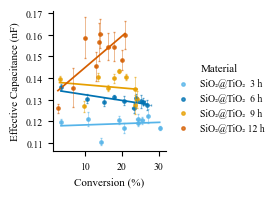

In [94]:
g = sns.lmplot(
    data=df_conv,
    x='conv',
    y='eff_cap_nF',
    hue='packing',
    hue_order=packing_order,
    palette=packing_colors,
    height=5/2.54,
    aspect=1,
    scatter_kws={'s': 6, 'alpha': alpha},
    line_kws={'lw': 1.25},
    ci=None
)

ax = g.axes.flatten()[0]

for packing in df_conv['packing'].unique():
    subset = df_conv[df_conv['packing'] == packing]
    ax.errorbar(
        x=subset['conv'],
        y=subset['eff_cap_nF'],
        xerr=subset['conv_err'],
        yerr=subset['eff_cap_nF_err'],
        fmt='none',
        ecolor=packing_colors[packing],
        elinewidth=0.5,
        capsize=1,
        capthick=0.95,
        alpha=0.6
    )

g.legend.set_title("Material", prop={'size': 8})
g.set_titles(col_template="{col_name}", size=9)
g.set_xlabels("Conversion (%)", size=8)
g.set_ylabels("Effective Capacitance (nF)", size=8)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_coating\figs\sander_eff_cap_vs_conv.pdf",
    bbox_inches='tight'
)
plt.show()

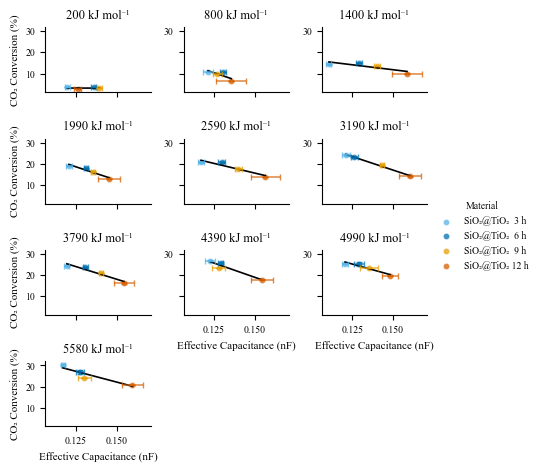

In [95]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='sei_ideal_kjmol',
    col_wrap=3,
    hue='packing',
    hue_order=packing_order,
    palette=packing_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'eff_cap_nF',
    'conv',
    s=20,
    alpha=alpha
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, fitting_subset) in zip(
    g.axes.flat,
    df_conv.groupby(['sei_ideal_kjmol'], sort=False)
    ):
    # Apply regplot to the current fitting_subset and axis
    sns.regplot(
        x='eff_cap_nF',
        y='conv',
        data=fitting_subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )
    for packing in fitting_subset['packing'].unique():
        error_subset = fitting_subset[fitting_subset['packing'] == packing]
        ax.errorbar(
            x=error_subset['eff_cap_nF'],
            y=error_subset['conv'],
            xerr=error_subset['eff_cap_nF_err'],
            yerr=error_subset['conv_err'],
            fmt='none',
            ecolor=packing_colors[packing],
            elinewidth=1.1,
            capsize=2,
            alpha=alpha
        )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(col_template="{col_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="Effective Capacitance (nF)",
    y_var="CO₂ Conversion (%)",
    size=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_coating\figs\sander_conv_vs_eff_cap_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()